In [1]:
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import sklearn.model_selection as md
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, recall_score
import numpy as np
import pickle
import pandas as pd
import seaborn as sb
import statsmodels.api as stats
import statsmodels
import warnings

In [2]:
# Load and separate the dataset
with open('../GABI/model_optimisation/balanced_epochs.pickle', 'rb') as handle:
    balanced = pickle.load(handle)
trainset = balanced[balanced['Holdout']==0]

warnings.filterwarnings("ignore",category=UserWarning)

We optimise hyperparameters for the random forest using the following method parameters.
Method: cross-validated grid search, ie. `GridSearchCV`  
Scoring: weighted f1  
Stratification: leave-one-group-out (LOGO) (using subject ID for groups)  
Sample weights: by amount of rater agreement, ie. `abs((isartefact.sum(axis=1)-3.5)/3.5)`  

We use the set of hyperparameters with the best f1 score to predict a set of classifications.

{'max_depth': 10, 'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Sensitivity: 0.7605633802816901
Specificity: 0.9516728624535316
Balanced Accuracy: 0.8561181213676108


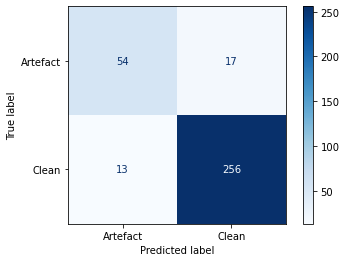

In [3]:
predictornames = ['LogVariance', 'Skew', 'Kurtosis', 'DeltaV',
    'LogHalfHzPwr', 'Lambda', 'Fiterror', 'DeltaLambda', 'DeltaFiterror',
    'DeltaLogPower', 'ThetaLambda', 'ThetaFiterror', 'ThetaLogPower',
    'AlphaLambda', 'AlphaFiterror', 'AlphaLogPower', 'BetaLambda',
    'BetaFiterror', 'BetaLogPower', 'GammaLambda', 'GammaFiterror',
    'GammaLogPower', 'SumDv50', 'SumDv100', 'SumDv200', 'SumDv300',
'SumDv500', 'HiguchiFD', 'KatzFD', 'Wavelet1', 'Wavelet2', 'Wavelet6']

with open('model_optimisation/gridoptresults.pickle', 'rb') as handle:
    opt = pickle.load(handle)

# subdivide by agreement
isartefact = trainset[['A','B','C','D','E','F','G']]=="Artefact"
subset_idx = ((abs(isartefact.sum(axis=1)-3.5))+3.5).astype(int)>=0
subset = trainset.loc[subset_idx]
y_pred = opt.y_pred[subset_idx]

ConfusionMatrixDisplay.from_predictions(subset.GroupDecision, y_pred, cmap='Blues')
print(opt.best_params_)
print('Sensitivity: {}'.format(recall_score(subset.GroupDecision, y_pred, pos_label='Artefact')))
print('Specificity: {}'.format(recall_score(subset.GroupDecision, y_pred, pos_label='Clean')))
print('Balanced Accuracy: {}'.format(balanced_accuracy_score(subset.GroupDecision, y_pred)))

/var/folders/yg/yfhbyjpd563djhtn3nz0pfg40000gn/T/ipykernel_72066/38819355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainset['Agreement'] = ((abs(isartefact.sum(axis=1)-3.5))+3.5).astype(int)


(0.0, 1.0)

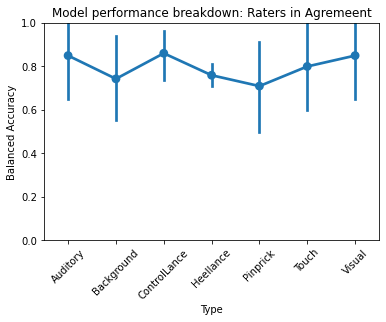

In [4]:
isartefact = trainset[['A','B','C','D','E','F','G']]=="Artefact"
trainset['Agreement'] = ((abs(isartefact.sum(axis=1)-3.5))+3.5).astype(int)
colname = 'Type'
types = np.unique(trainset[colname])
scores = pd.DataFrame()
scoresmn = np.zeros_like(types)
scoressd = np.zeros_like(types)
for n, type in enumerate(types):
    subset = trainset.loc[trainset[colname]==type]
    scores[type] = md.cross_val_score(opt.best_estimator_, subset[predictornames], subset.GroupDecision, scoring='balanced_accuracy',
                            cv=md.StratifiedGroupKFold(n_splits=5, shuffle=True).split(subset, y=subset.AgeTypeGroup, groups=subset.ID))
scores = pd.melt(scores, value_vars=types)
sb.pointplot(data=scores, x='variable', y='value')
plt.ylabel('Balanced Accuracy')
plt.xticks(rotation=45)
plt.title('Model performance breakdown: {}'.format('Raters in Agremeent'))
plt.xlabel(colname)
plt.ylim((0,1))

In [5]:
isartefact = trainset[['A','B','C','D','E','F','G']]=="Artefact"
test = ((abs(isartefact.sum(axis=1)-3.5))+3.5).astype(int)

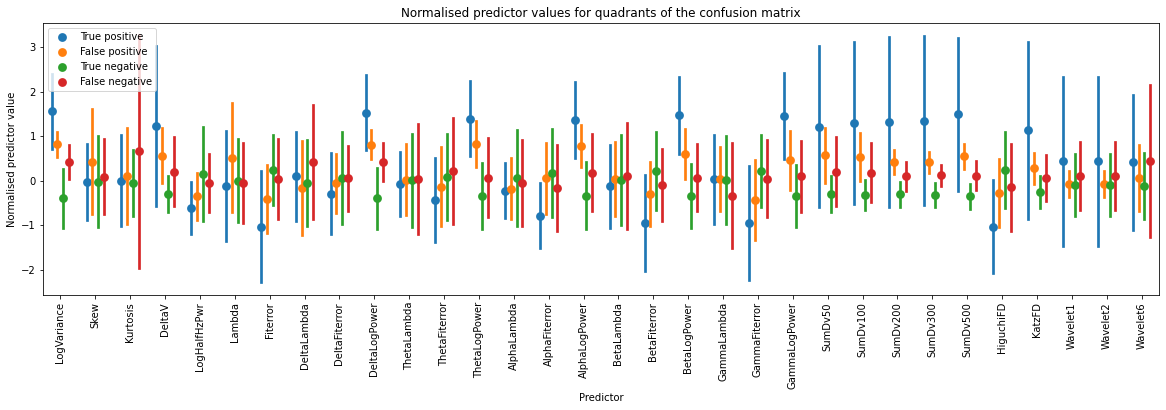

In [6]:
use_subset = False
test = trainset.copy()
isartefact = trainset[['A','B','C','D','E','F','G']]=="Artefact"
if use_subset:
    subset = ((abs(isartefact.sum(axis=1)-3.5))+3.5).astype(int)==7
    test = test.loc[subset]
    test['ConfusionCorner'] = test.GroupDecision + y_pred[subset]
else:
    test['ConfusionCorner'] = test.GroupDecision + y_pred
test[predictornames] = (test[predictornames]-test[predictornames].mean())/test[predictornames].std()
test = pd.melt(test, id_vars='ConfusionCorner',value_vars=predictornames)
plt.rcParams["figure.figsize"] = (20,5)
ax = sb.pointplot(x='variable', y='value', hue='ConfusionCorner', data=test, dodge=0.5, join=False, ci="sd")
plt.xticks(rotation=90)
plt.xlabel('Predictor')
plt.ylabel('Normalised predictor value')
plt.title('Normalised predictor values for quadrants of the confusion matrix')
plt.legend(handles=ax.axes.get_legend_handles_labels()[0], labels=['True positive','False positive','True negative','False negative'], loc='upper left')
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset defaults

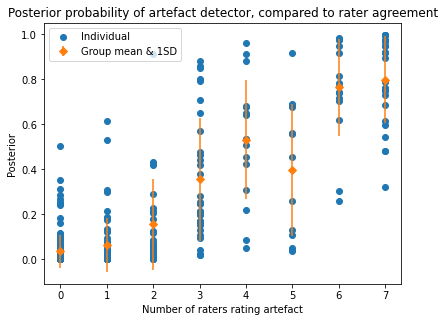

In [7]:
numratingartefact = (isartefact.sum(axis=1)).astype(int)
X = trainset[predictornames] # predictors
posteriors = md.cross_val_predict(opt.best_estimator_, X, np.ravel(trainset['GroupDecision'].to_numpy()), 
            cv=md.LeaveOneGroupOut(), groups=trainset['ID'].to_numpy(), 
            n_jobs=-1, method='predict_proba')[:,0]
posterior_means = np.zeros(8)
posterior_stds = np.zeros(8)
for n in range(8):
    posterior_means[n] = np.mean(posteriors[numratingartefact==n])
    posterior_stds[n] = np.std(posteriors[numratingartefact==n])
plt.scatter(numratingartefact, posteriors, label='Individual')
plt.errorbar(range(8),posterior_means, yerr=posterior_stds, fmt='C1D', label='Group mean & 1SD')
plt.ylabel('Posterior')
plt.xlabel('Number of raters rating artefact')
plt.title('Posterior probability of artefact detector, compared to rater agreement')
plt.legend()

In [8]:
def LOObalacc(resultstable, LOO_col):
    LOO_table = resultstable.drop(columns=[LOO_col])
    y_true = LOO_table.mode(1)
    y_pred = resultstable[LOO_col]
    return balanced_accuracy_score(y_true=='Artefact', y_pred=='Artefact')

raterdecisions = trainset[['A','B','C','D','E','F','G']]
raterdecisions['Classifier'] = opt.y_pred
balaccs = np.zeros(8)
for n, rater in enumerate(['A','B','C','D','E','F','G','Classifier']):
    balaccs[n] = LOObalacc(raterdecisions, rater)


/var/folders/yg/yfhbyjpd563djhtn3nz0pfg40000gn/T/ipykernel_72066/1510657489.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raterdecisions['Classifier'] = opt.y_pred


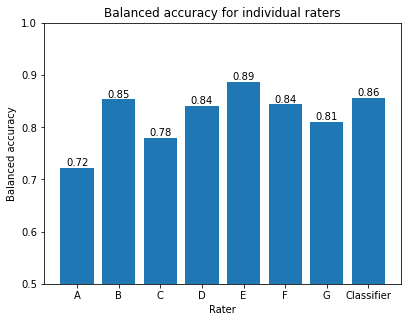

In [9]:
bars = plt.bar(raterdecisions.columns, balaccs)
plt.title('Balanced accuracy for individual raters')
plt.ylabel('Balanced accuracy')
plt.ylim([0.5,1])
plt.xlabel('Rater')
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

In [10]:
# Log some features, for easier display
Xlog = trainset.loc[:,predictornames]
feattolog = ['Kurtosis','DeltaV','SumDv50','SumDv100','SumDv200','SumDv300','SumDv500','Wavelet1','Wavelet2','Wavelet6']
for col in Xlog.columns:
    if col in feattolog:
        Xlog.loc[:,col] = np.log10(Xlog.loc[:,col])
Xlog = Xlog.rename(columns={col:'Log'+col for col in feattolog})

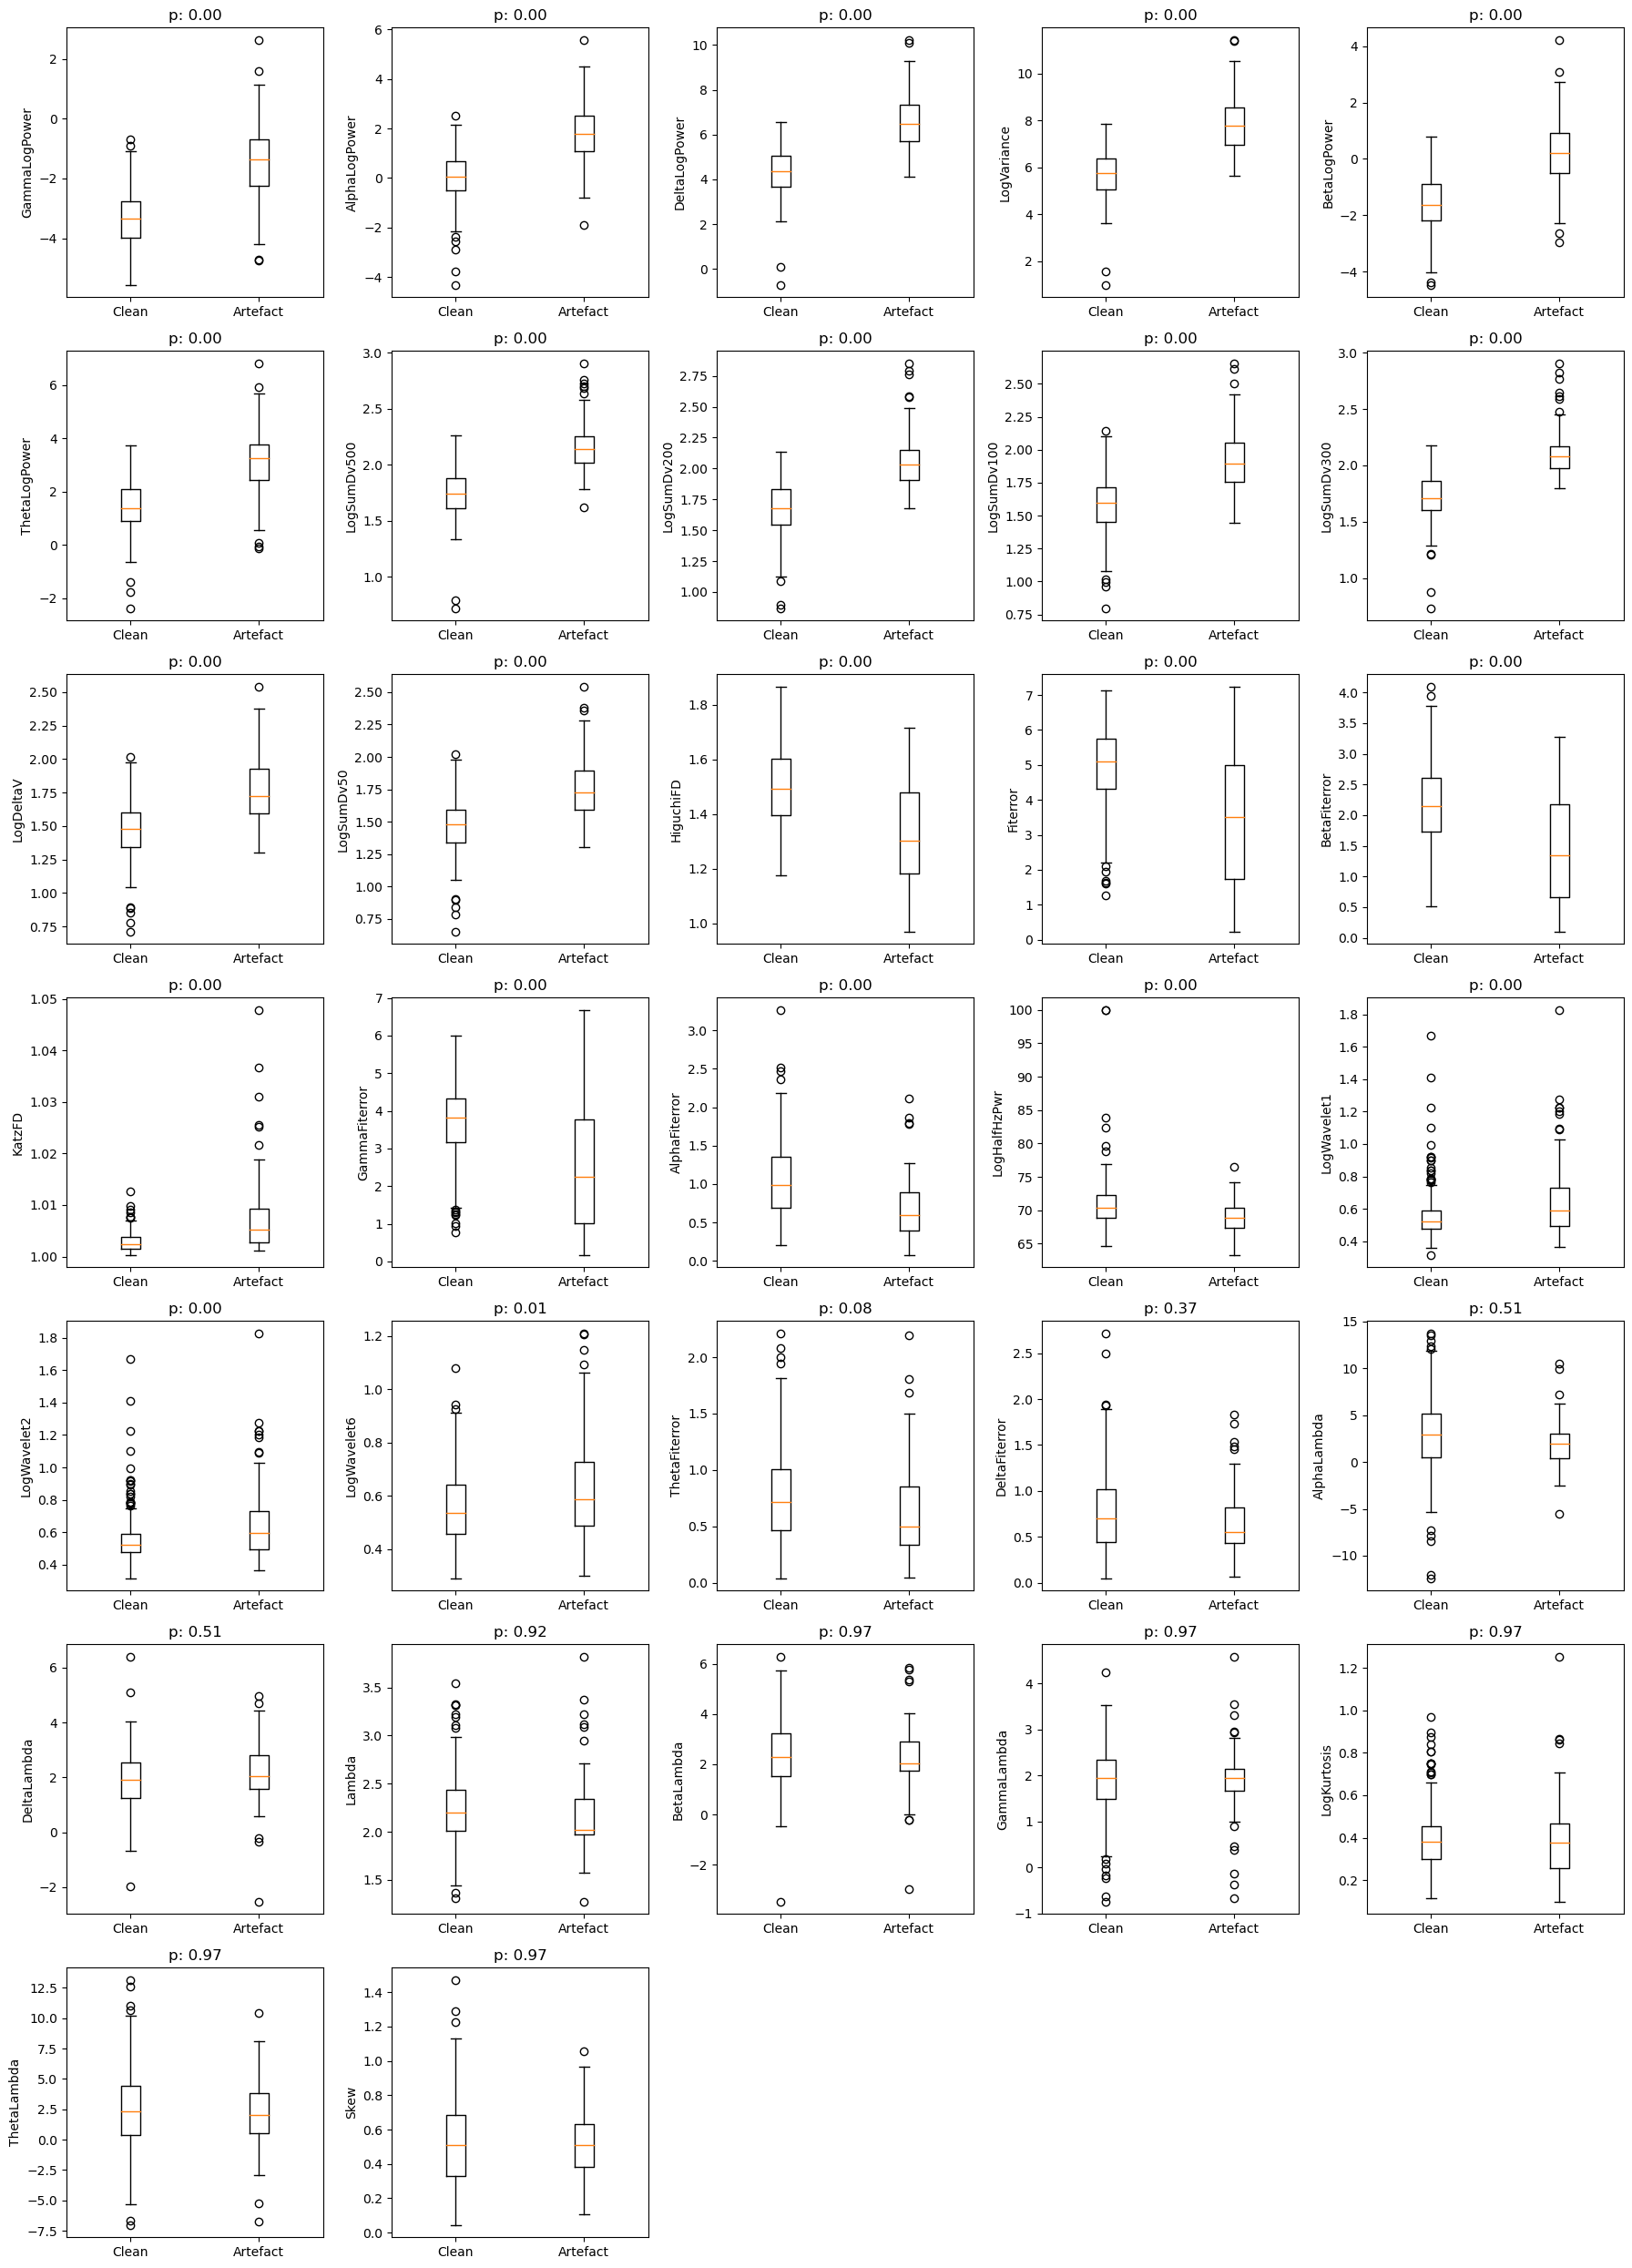

In [11]:
# Order features by p-value
y = trainset.GroupDecision
pvalues = np.zeros_like(Xlog.columns)
for col, featname in enumerate(Xlog.columns):
    feat = Xlog.loc[:,featname]
    x01 = stats.tools.add_constant(feat)
    model = statsmodels.discrete.discrete_model.MNLogit(y,x01).fit(disp=0)
    pvalues[col] = model.pvalues.loc[featname,0]

sortedfeatures = [x for _, x in sorted(zip(pvalues, Xlog.columns))]
[_,sortedpvalues,_,bonferroni_p] = statsmodels.stats.multitest.multipletests(sorted(pvalues))

# Plot feature correlation with response
for col, featname in enumerate(sortedfeatures):
    feat = Xlog.loc[:,featname]
    plt.subplot(7,5,col+1)
    plt.gcf().set_dpi(100)
    plt.gcf().set_size_inches(18,25)
    plt.boxplot([feat.loc[y.to_numpy()=='Clean'],feat.loc[y.to_numpy()=='Artefact']])
    plt.xticks([1,2],['Clean','Artefact'])
    plt.ylabel(featname)
    plt.title('p: {:.2f}'.format(sortedpvalues[col]))
plt.tight_layout()

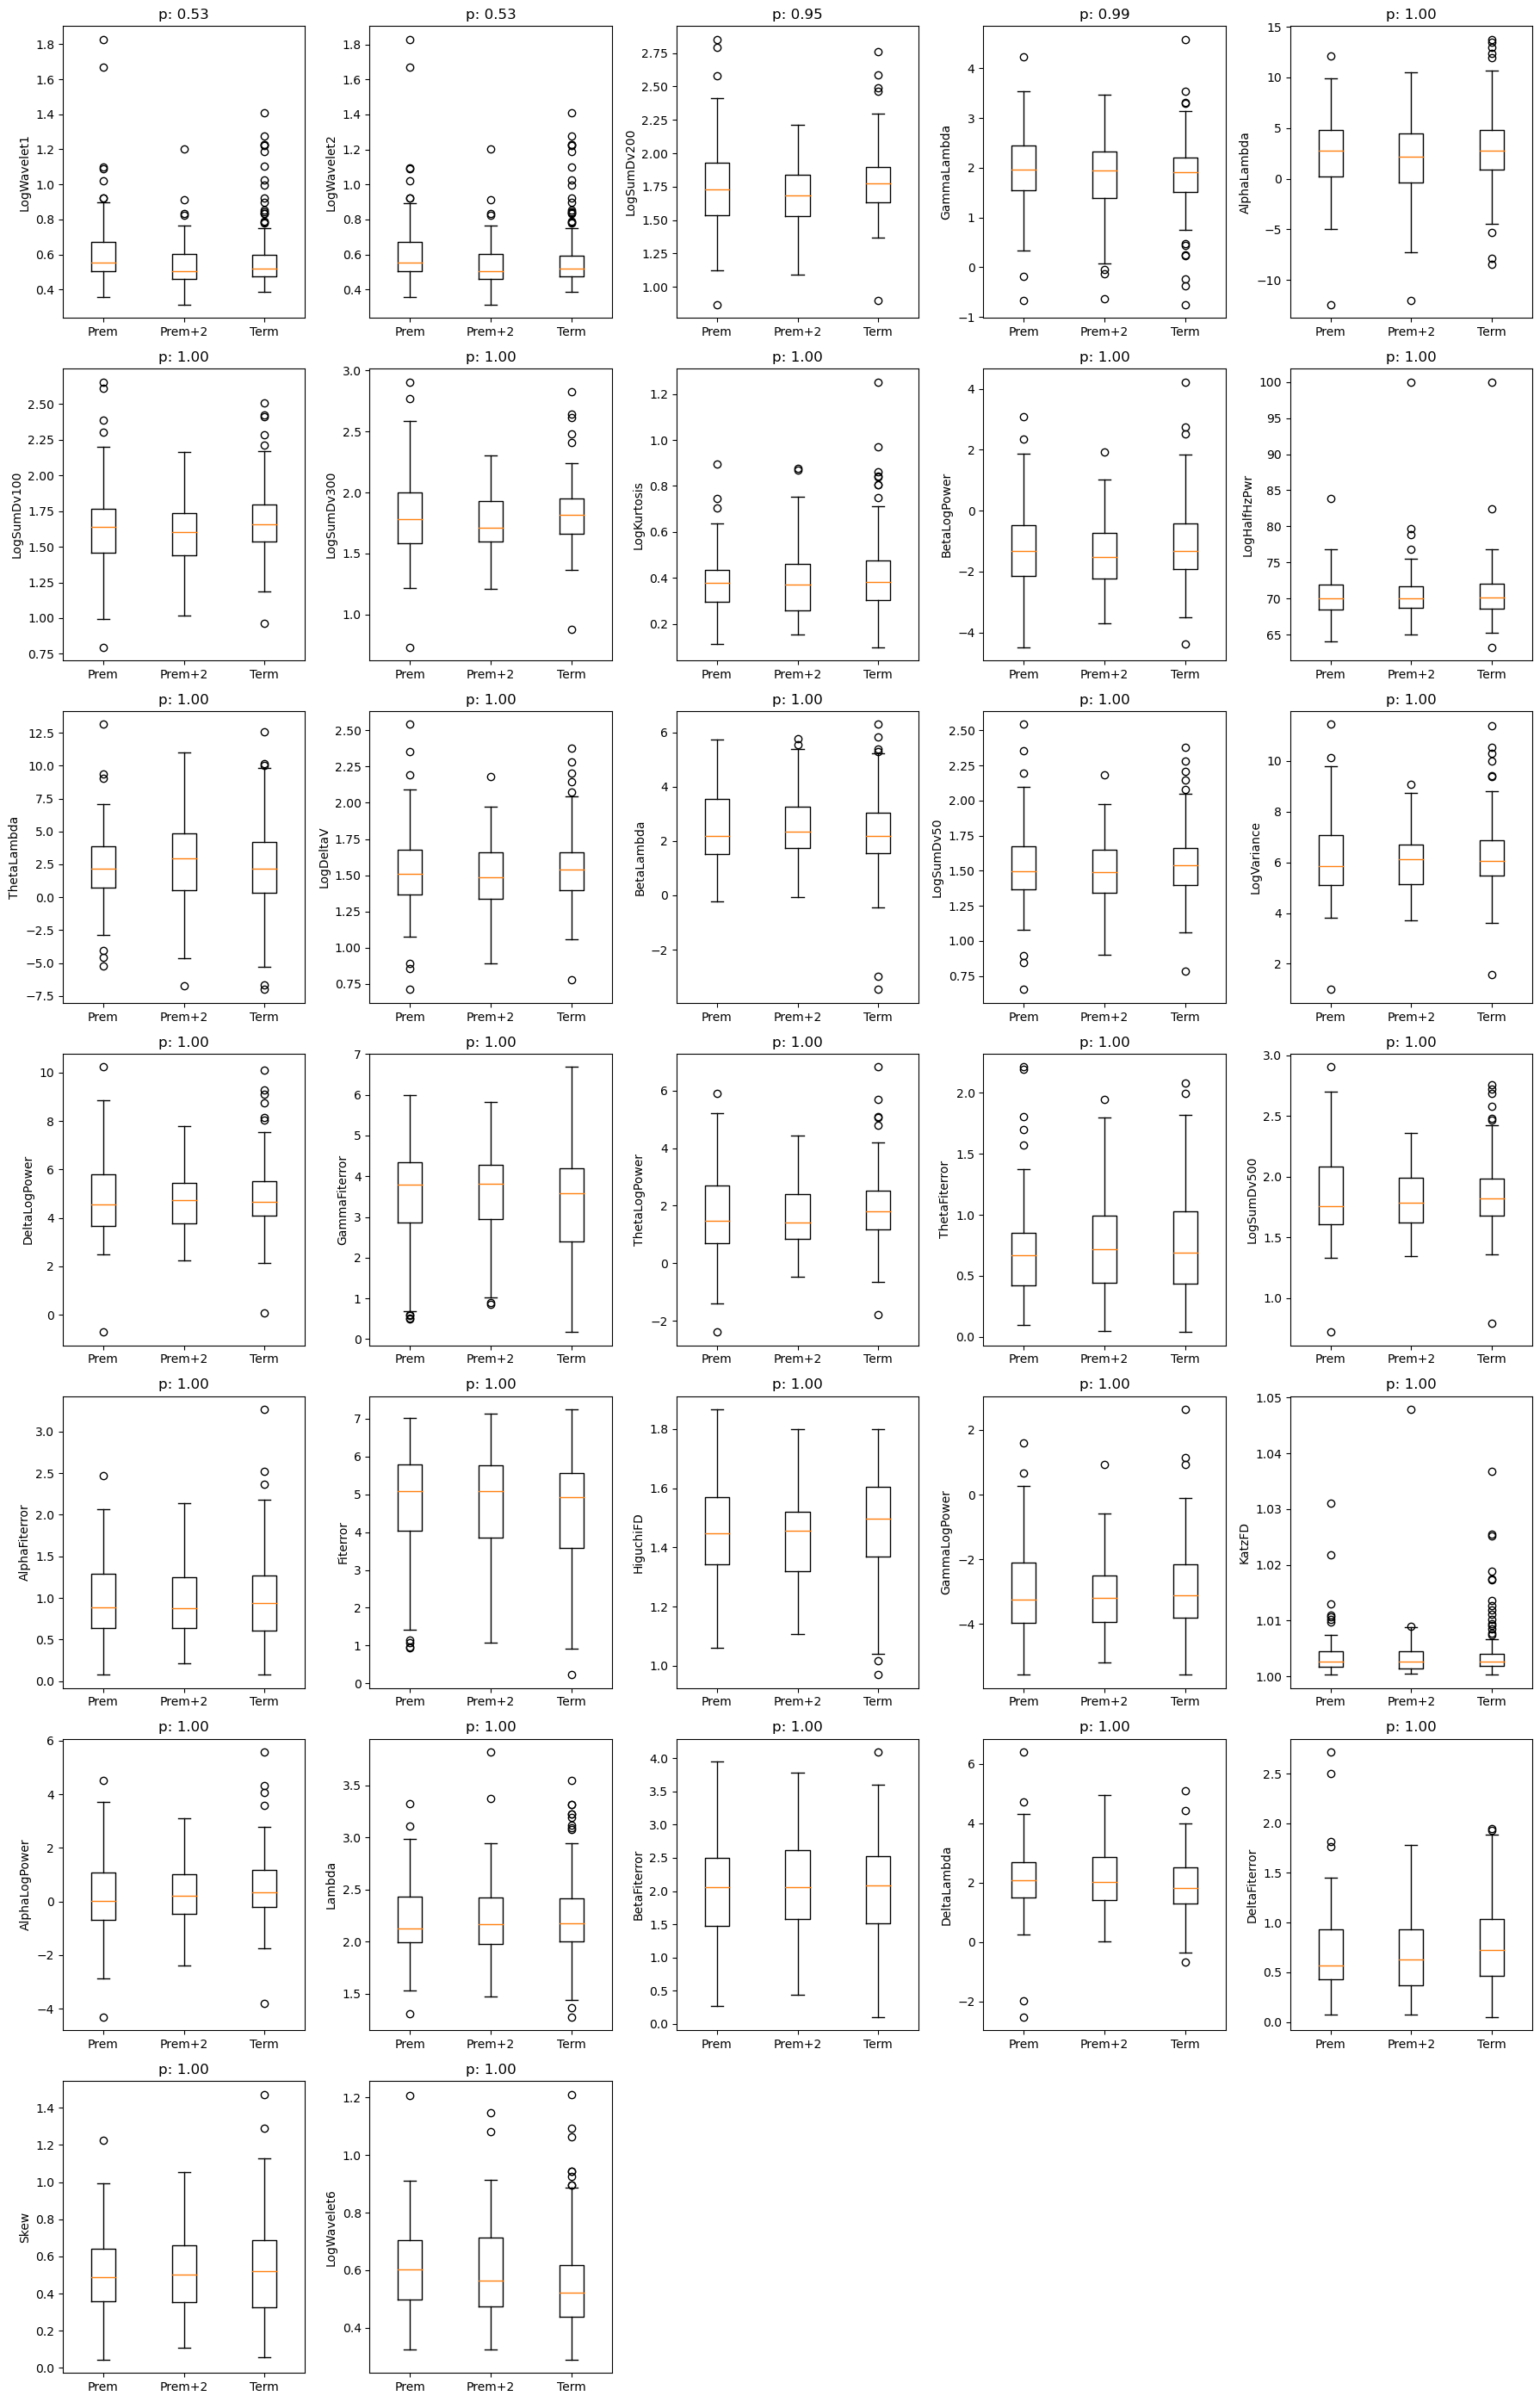

In [12]:
# Same for age
y = trainset.AgeGroup
# Order features by p-value
pvalues = np.zeros_like(Xlog.columns)
for col, featname in enumerate(Xlog.columns):
    feat = Xlog.loc[:,featname]
    x01 = stats.tools.add_constant(feat)
    model = statsmodels.discrete.discrete_model.MNLogit(y,x01).fit(disp=0)
    pvalues[col] = model.pvalues.loc[featname,0]

sortedfeatures = [x for _, x in sorted(zip(pvalues, Xlog.columns))]
[_,sortedpvalues,_,bonferroni_p] = statsmodels.stats.multitest.multipletests(sorted(pvalues))

# Plot feature correlation with response
for col, featname in enumerate(sortedfeatures):
    feat = Xlog.loc[:,featname]
    plt.subplot(7,5,col+1)
    plt.gcf().set_dpi(100)
    plt.gcf().set_size_inches(18,28)
    plt.boxplot([feat.loc[y.to_numpy()=='Prem'],feat.loc[y.to_numpy()=='Prem+2'],feat.loc[y.to_numpy()=='Term']])
    plt.xticks([1,2,3],['Prem','Prem+2','Term'])
    plt.ylabel(featname)
    plt.title('p: {:.2f}'.format(sortedpvalues[col]))
plt.tight_layout()

{'C': 1000.0, 'kernel': 'linear'}
Sensitivity: 0.7887323943661971
Specificity: 0.929368029739777
Balanced Accuracy: 0.859050212052987
McNemar comparison with randomforest, p: 0.5


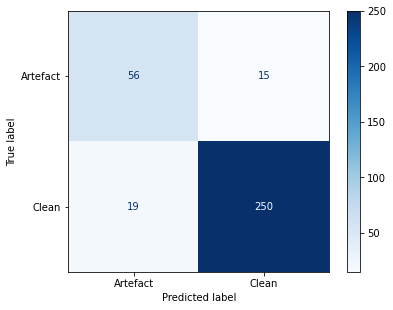

In [13]:
# Alright so let's test SVM as a method, too.
with open('model_optimisation/gridoptresults_svm.pickle', 'rb') as handle:
    opt = pickle.load(handle)
y_pred = opt.y_pred
ConfusionMatrixDisplay.from_predictions(trainset.GroupDecision, y_pred, cmap='Blues')
print(opt.best_params_)
print('Sensitivity: {}'.format(recall_score(trainset.GroupDecision, y_pred, pos_label='Artefact')))
print('Specificity: {}'.format(recall_score(trainset.GroupDecision, y_pred, pos_label='Clean')))
print('Balanced Accuracy: {}'.format(balanced_accuracy_score(trainset.GroupDecision, y_pred)))

# Compare with randomforest
with open('model_optimisation/gridoptresults.pickle', 'rb') as handle:
    oldypred = pickle.load(handle).y_pred
contingency = statsmodels.stats.contingency_tables.Table.from_data(pd.DataFrame({'new':y_pred==trainset.GroupDecision, 'old':oldypred==trainset.GroupDecision}))
mcnemar = statsmodels.stats.contingency_tables.mcnemar(contingency.table_orig).pvalue
print('McNemar comparison with randomforest, p: {:.2}'.format(mcnemar))

{'learning_rate': 1, 'n_estimators': 100}
Sensitivity: 0.8169014084507042
Specificity: 0.9479553903345725
Balanced Accuracy: 0.8824283993926384
McNemar comparison with randomforest, p: 0.65


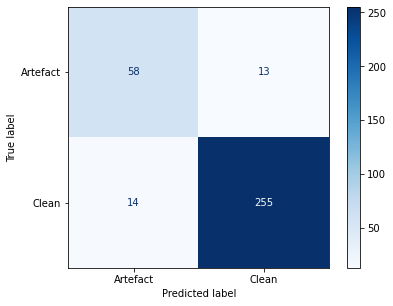

In [14]:
# and ADABOOST. 
with open('model_optimisation/gridoptresults_adaboost.pickle', 'rb') as handle:
    opt = pickle.load(handle)
y_pred = opt.y_pred
y_pred = np.where(y_pred=='Artef', 'Artefact', 'Clean')
ConfusionMatrixDisplay.from_predictions(trainset.GroupDecision, y_pred, cmap='Blues')
print(opt.best_params_)
print('Sensitivity: {}'.format(recall_score(trainset.GroupDecision, y_pred, pos_label='Artefact')))
print('Specificity: {}'.format(recall_score(trainset.GroupDecision, y_pred, pos_label='Clean')))
print('Balanced Accuracy: {}'.format(balanced_accuracy_score(trainset.GroupDecision, y_pred)))

# Compare with randomforest
with open('model_optimisation/gridoptresults.pickle', 'rb') as handle:
    oldypred = pickle.load(handle).y_pred
contingency = statsmodels.stats.contingency_tables.Table.from_data(pd.DataFrame({'new':y_pred==trainset.GroupDecision, 'old':oldypred==trainset.GroupDecision}))
mcnemar = statsmodels.stats.contingency_tables.mcnemar(contingency.table_orig).pvalue
print('McNemar comparison with randomforest, p: {:.2}'.format(mcnemar))

{'learning_rate': 0.1, 'n_estimators': 100000}
Sensitivity: 0.704225352112676
Specificity: 0.9591078066914498
Balanced Accuracy: 0.8316665794020629
McNemar comparison with randomforest, p: 0.8


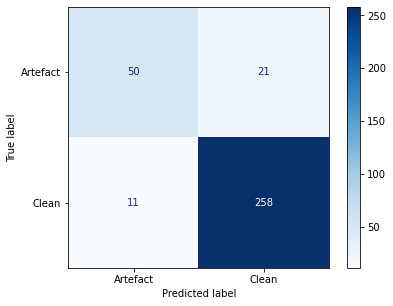

In [15]:
# and RUSBOOST.
with open('model_optimisation/gridoptresults_rusboost.pickle', 'rb') as handle:
    opt = pickle.load(handle)
y_pred = opt.y_pred
y_pred = np.where(y_pred=='Artef', 'Artefact', 'Clean')
ConfusionMatrixDisplay.from_predictions(trainset.GroupDecision, y_pred, cmap='Blues')
print(opt.best_params_)
print('Sensitivity: {}'.format(recall_score(trainset.GroupDecision, y_pred, pos_label='Artefact')))
print('Specificity: {}'.format(recall_score(trainset.GroupDecision, y_pred, pos_label='Clean')))
print('Balanced Accuracy: {}'.format(balanced_accuracy_score(trainset.GroupDecision, y_pred)))

# Compare with randomforest
with open('model_optimisation/gridoptresults.pickle', 'rb') as handle:
    oldypred = pickle.load(handle).y_pred
contingency = stats.stats.Table.from_data(pd.DataFrame({'new':y_pred==trainset.GroupDecision, 'old':oldypred==trainset.GroupDecision}))
mcnemar = stats.stats.mcnemar(contingency.table_orig).pvalue
print('McNemar comparison with randomforest, p: {:.2}'.format(mcnemar))

Sensitivity: 0.6470588235294118
Specificity: 0.9811320754716981
Balanced Accuracy: 0.814095449500555


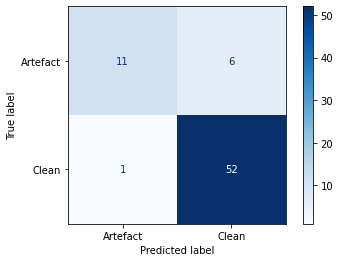

In [85]:
# Open the held-out dataset and test the randomforest model on it.
testset = balanced[balanced['Fold']==0]
trainset = balanced[balanced['Fold']!=0]
predictornames = ['LogVariance', 'Skew', 'Kurtosis', 'DeltaV',
    'LogHalfHzPwr', 'Lambda', 'Fiterror', 'MaxSpecDev', 'DeltaLambda', 'DeltaFiterror',
    'DeltaLogPower', 'ThetaLambda', 'ThetaFiterror', 'ThetaLogPower',
    'AlphaLambda', 'AlphaFiterror', 'AlphaLogPower', 'BetaLambda',
    'BetaFiterror', 'BetaLogPower', 'GammaLambda', 'GammaFiterror',
    'GammaLogPower', 'SumDv50', 'SumDv100', 'SumDv200', 'SumDv300',
'SumDv500', 'HiguchiFD', 'KatzFD', 'Wavelet1', 'Wavelet2', 'Wavelet6']
X = trainset[predictornames].to_numpy() # predictors
y = np.ravel(trainset['GroupDecision'].to_numpy()) # response
groups = trainset['ID'].to_numpy() # grouping variables for splits
isartefact = trainset[['A','B','C','D','E','F','G']]=="Artefact"
weights = abs((isartefact.sum(axis=1)-3.5)/3.5)

with open('model_optimisation/gridoptresults.pickle', 'rb') as handle:
    opt = pickle.load(handle)
clf = RandomForestClassifier(**opt.best_params_)
clf.fit(X, y, sample_weight=weights)

y_pred_test = clf.predict(testset[predictornames])
ConfusionMatrixDisplay.from_predictions(testset.GroupDecision, y_pred_test, cmap='Blues')
print('Sensitivity: {}'.format(recall_score(testset.GroupDecision, y_pred_test, pos_label='Artefact')))
print('Specificity: {}'.format(recall_score(testset.GroupDecision, y_pred_test, pos_label='Clean')))
print('Balanced Accuracy: {}'.format(balanced_accuracy_score(testset.GroupDecision, y_pred_test)))

/var/folders/yg/yfhbyjpd563djhtn3nz0pfg40000gn/T/ipykernel_1987/3041362444.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raterdecisions['Classifier'] = y_pred_test


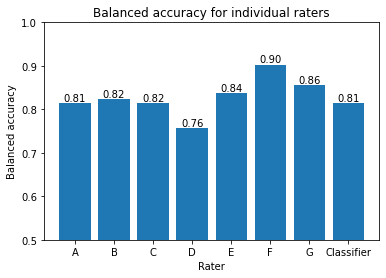

In [86]:
def LOObalacc(resultstable, LOO_col):
    LOO_table = resultstable.drop(columns=[LOO_col])
    y_true = LOO_table.mode(1)
    y_pred = resultstable[LOO_col]
    return balanced_accuracy_score(y_true=='Artefact', y_pred=='Artefact')

raterdecisions = testset[['A','B','C','D','E','F','G']]
raterdecisions['Classifier'] = y_pred_test
balaccs = np.zeros(8)
for n, rater in enumerate(['A','B','C','D','E','F','G','Classifier']):
    balaccs[n] = LOObalacc(raterdecisions, rater)


bars = plt.bar(raterdecisions.columns, balaccs)
plt.title('Balanced accuracy for individual raters')
plt.ylabel('Balanced accuracy')
plt.ylim([0.5,1])
plt.xlabel('Rater')
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

In [94]:
clf.predictornames = predictornames
with open('../RFclassifier.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)